In [1]:
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random






In [11]:

# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,2,8,-4,4,-2,4]),np.zeros(90))
beta_2=np.append(np.array([-2,-2,4,-2,1,-4,2,-2,-1,2]),np.zeros(90))
beta_3=np.append(np.array([-1.5,-1.5,3,-1.5,-0.75,-3,1.5,-1.5,0.75,1.5]),np.zeros(90))
beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)
n1=200
n2=175
n3=150
p=100
corval=0
prior=5

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generaet_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    y=torch.tensor(y,dtype=torch.double)

    return x,y


In [22]:

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generaet_data(corval,beta_1,n1,p)
x2,y2=generaet_data(corval,beta_2,n2,p)
x3,y3=generaet_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


In [23]:
train_x1

tensor([[ 1.1562e+00, -6.7676e-01, -2.9011e-02,  ..., -1.0559e+00,
         -1.4391e+00, -6.0677e-01],
        [-3.5220e-01,  1.6572e-01,  1.4609e+00,  ..., -1.6776e+00,
         -1.3760e-03,  7.8600e-01],
        [ 9.6538e-01, -3.3180e-01,  1.0211e+00,  ..., -1.2069e-01,
         -1.0751e+00, -3.9528e-01],
        ...,
        [-1.0532e+00,  2.7305e-01,  3.2043e-01,  ...,  2.4501e+00,
         -4.6602e-02, -4.2758e-01],
        [ 2.1007e-01, -4.2998e-02,  1.1864e+00,  ...,  6.7503e-01,
         -8.6875e-01,  4.5822e-01],
        [ 6.1372e-01, -8.2253e-02, -1.4422e-01,  ...,  6.7524e-01,
          2.2452e-02, -8.7104e-01]])

In [39]:
################## training stage ##################
    
# set hyperparamters
lambda1,lambda2 = 0.01,0.0001
learning_rate=0.1
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out 
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300,600,900], gamma=0.01)

# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization

    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


In [40]:
BCE_loss_1
BCE_loss

tensor(0.0162, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0334, grad_fn=<AddBackward0>)

In [41]:
################## testing stage ##################

# compute predictions on test set
prediction_1= (model_1(test_x1)[0]>0.5).clone().double()
target_1= test_y1.reshape(-1,1)

# compute metrics
accuracy_score(target_1,prediction_1)
precision_score(target_1,prediction_1)
recall_score(target_1,prediction_1)#TPR
confusion_matrix_1=confusion_matrix(target_1,prediction_1)
confusion_matrix_1[0,0]/(sum(confusion_matrix_1[0,:]))#TNR
f1_score(target_1,prediction_1)
confusion_matrix(target_1,prediction_1)

0.625

0.6428571428571429

0.47368421052631576

0.7619047619047619

0.5454545454545454

array([[16,  5],
       [10,  9]])

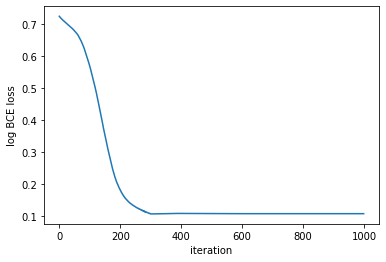

In [10]:
# decaying curve of loss 
## in log scale

fig, ax = plt.subplots()
_=ax.plot(np.log(BCE))
_=ax.set_xlabel("iteration")
_=ax.set_ylabel("log BCE loss")


In [8]:
################## packaging into function ##################

def hyperparameter_tuning(inputs,targets,test_inputs,test_targets,lambda1,lambda2,learning_rate, max_iteration):


    # record loss descent
    BCE=[]

    # main nn object
    class MLP(torch.nn.Module):
        def __init__(self):
            super(MLP, self).__init__()
            self.linear1 = torch.nn.Linear(100,100)
            self.linear2 = torch.nn.Linear(100,10)
            self.linear3 = torch.nn.Linear(10,10)
            self.linear4 = torch.nn.Linear(10,1)

        def forward(self, x):
            layer1_out = F.relu(self.linear1(x))
            layer2_out = F.relu(self.linear2(layer1_out))
            layer3_out = F.relu(self.linear3(layer2_out))
            out= torch.sigmoid(self.linear4(layer3_out))
            return out, layer1_out, layer2_out,layer3_out 




    model = MLP()
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    # learning rate decay scheme
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300,600,900], gamma=0.05)

    # loop for max_iteration times
    for t in range(max_iteration):

        # renew optimizer
        optimizer.zero_grad()

        # forward propagate
        out, layer1_out, layer2_out,layer3_out= model(inputs)



        # extract parameters
        #[:-1] for leaving out bias term#
        all_linear1_params = torch.cat([x.view(-1) for x in model.linear1.parameters()][:-1])
        all_linear2_params = torch.cat([x.view(-1) for x in model.linear2.parameters()][:-1])

        # compute loss
        BCE_loss = loss_fn(out, targets.reshape(-1,1))
        l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)
        l2_regularization = lambda2 * torch.norm(all_linear2_params, 2)
        loss = BCE_loss + l1_regularization + l2_regularization

        # record loss
        BCE.append(BCE_loss.item())

        # compute derivative
        loss.backward()

        # gradient descent
        optimizer.step()

        # learning rate decay
        scheduler.step()
        
        
    # compute predictions on test set
    prediction  = (model(test_inputs)[0]>0.5).clone().double()
    

    # compute metrics
    acc=accuracy_score(prediction,test_targets)
    pre=precision_score(prediction,test_targets)
    recall=recall_score(prediction,test_targets)
    f1=f1_score(prediction,test_targets)
    cof_mat=confusion_matrix(prediction,test_targets)
    
    # compute sparsity
    sparsity=np.array(torch.cat([x.view(-1) for x in model.linear1.parameters()][:-1]).detach().abs()>1e-5).mean()
    
    
    return {"acc":acc,"pre":pre,
            "recall":recall,"f1":f1,
            "cof_mat":cof_mat,"sparsity":sparsity}

In [9]:

# repeated experiment
repeat_time=3

# parameter grid
lamda1_vec=[i for i in np.logspace(-4,-1,5)]
lamda2_vec=[i for i in np.logspace(-5,-2,5)]
learning_rate, max_iteration=0.1,1000

# criterion
criterion="acc"
criterion_vec=[]


# generate axis
grid_axis_1=lamda1_vec
grid_axis_2=lamda2_vec
axis1,axis2=np.meshgrid(grid_axis_1,grid_axis_2)
params=np.array([axis1.ravel(),axis2.ravel()]).T



for i in range(params.shape[0]):
    # print process
    if 10*i % int(params.shape[0])==0:
        print((i,params.shape[0]))
        
    # criterion average
    criterion_sum=0
    
    for j in range(repeat_time):

        # set seed
        _=torch.manual_seed(i*j+j+i)

        # simulation setting
        x1,y1=generaet_data(corval,beta_1,n1,p)
        test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
        inputs,targets = x1,y1
        test_inputs, test_targets = test_x1,test_y1
        
        
        # get metric
        result=hyperparameter_tuning(inputs,targets,test_inputs,test_targets,params[i,0],params[i,1],learning_rate, max_iteration)
        criterion_sum+=result[criterion]
    
    criterion_vec.append(criterion_sum/repeat_time)
    
criterion_mat=np.array(criterion_vec).reshape(-1,len(grid_axis_1))


(0, 25)


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(5, 25)


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(10, 25)


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(15, 25)


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(20, 25)


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'accuracy')

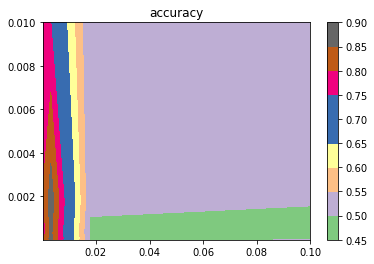

In [10]:
plt.contourf(axis1, axis2,criterion_mat ,cmap=plt.cm.Accent)
plt.colorbar()
plt.title("accuracy")



Text(0.5, 1.0, 'accuracy')

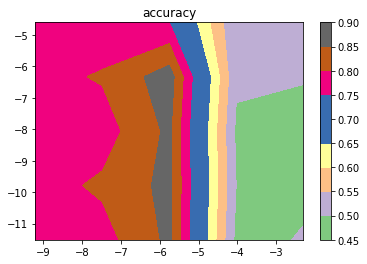

In [11]:
plt.contourf(np.log(axis1), np.log(axis2),criterion_mat ,cmap=plt.cm.Accent)
plt.colorbar()
plt.title("accuracy")

In [89]:
################## training stage ##################

# set hyperparamters
lambda1,lambda2 = 0.03,0.0001
learning_rate=0.1
max_iteration=1000

# switch training set
inputs,targets = train_x1,train_y1

# switching testing set
test_inputs, test_targets = test_x1,test_y1

# record loss descent
BCE=[]

# main nn object
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out 
    optimizer.zero_grad()
    
    # forward propagate
    out, layer1_out, layer2_out,layer3_out= model(inputs)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    all_linear1_params = model.linear1
    all_linear2_params = torch.cat([x.view(-1) for x in model.linear2.parameters()][:-1])

    # compute loss
    BCE_loss = loss_fn(out, targets.reshape(-1,1))
    l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)
    l2_regularization = lambda2 * torch.norm(all_linear2_params, 2)
    loss = BCE_loss + l1_regularization + l2_regularization
    
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()






RuntimeError: The size of tensor a (20) must match the size of tensor b (100) at non-singleton dimension 1